In [1]:
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [3]:
# dataset path
path = 'monet2photo/'

# load dataset A - Monet paintings
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=100,    
                 random_state=42) 

# load dataset B - Photos 
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=200,    
                 random_state=42) 

Loaded dataA:  (1072, 256, 256, 3)
Loaded dataB:  (6287, 256, 256, 3)


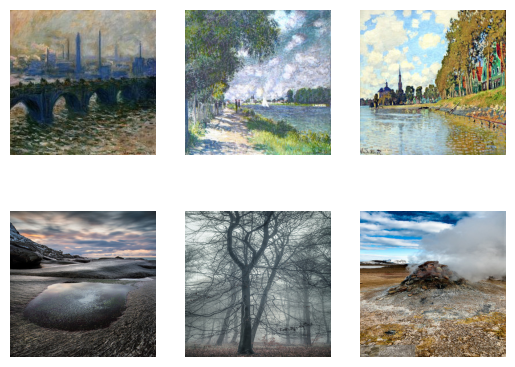

In [4]:
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

In [5]:
# load image data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

Loaded (100, 256, 256, 3) (200, 256, 256, 3)


In [6]:
#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

In [7]:
from cycleGAN_model import define_generator, define_discriminator, define_composite_model, train
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

c:\Users\Yago\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Yago\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If yo

In [8]:
from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=20)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 1s 523ms/step
Iteration>1, dA[0.941,1.367] dB[1.020,1.023] g[20.032,19.769]
1/1 [==============================] - 0s 20ms/step
Iteration>2, dA[0.896,1.743] dB[3.185,1.080] g[18.417,18.626]
1/1 [==============================] - 0s 17ms/step
Iteration>3, dA[3.490,2.567] dB[7.180,2.563] g[18.306,28.357]
1/1 [==============================] - 0s 10ms/step
Iteration>4, dA[23.373,1.784] dB[4.117,1.325] g[17.277,19.414]
1/1 [==============================] - 0s 21ms/step
Iteration>5, dA[5.209,1.598] dB[1.547,0.967] g[17.629,18.205]
1/1 [==============================] - 0s 16ms/step
Iteration>6, dA[8.777,1.377] dB[4.797,2.411] g[17.826,24.463]
1/1 [==============================] - 0s 10ms/step
Iteration>7, dA[1.584,1.249] dB[3.986,7.504] g[16.305,15.971]
1/1 [==============================] - 0s 12ms/step
Iteration>8, dA[0.889,1.868] dB[3.395,2.140] g[14.274,15.196]
1/1 [==============================] - 0s 15ms/step
Iteration>9, dA[1.711,2.006] dB[1.

In [14]:
# Use the saved cyclegan models for image translation
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	plt.figure(dpi=200)  # Cambia el DPI según sea necesario
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

1/1 [==============================] - 1s 663ms/step


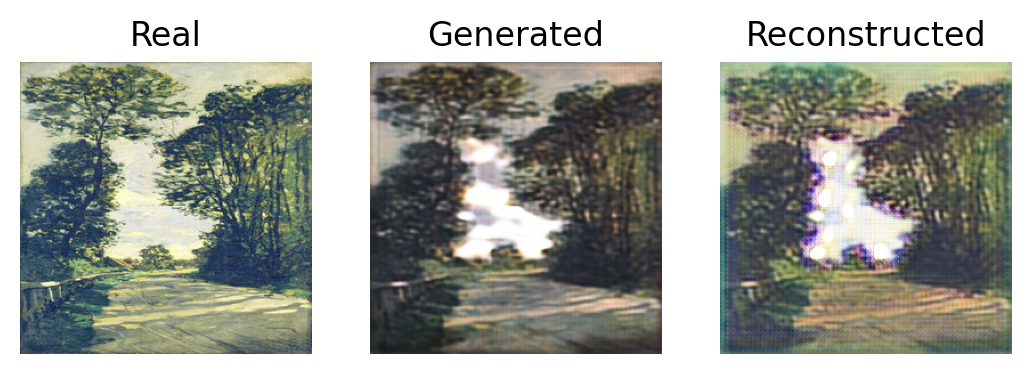

1/1 [==============================] - 0s 20ms/step


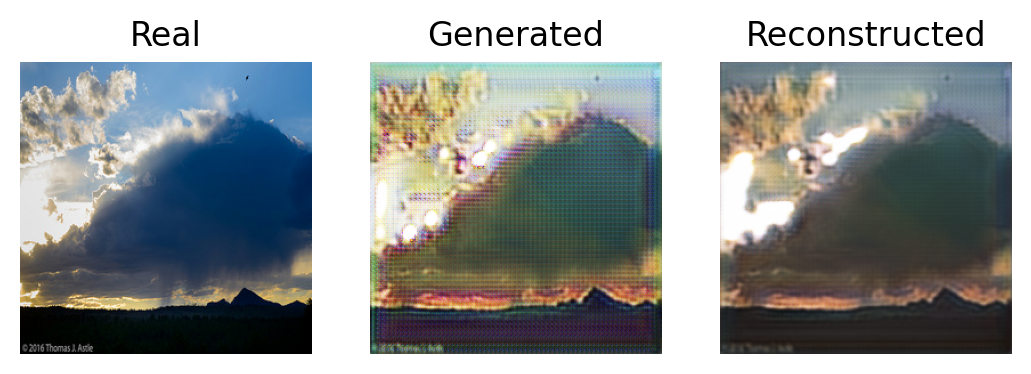

1/1 [==============================] - 0s 21ms/step


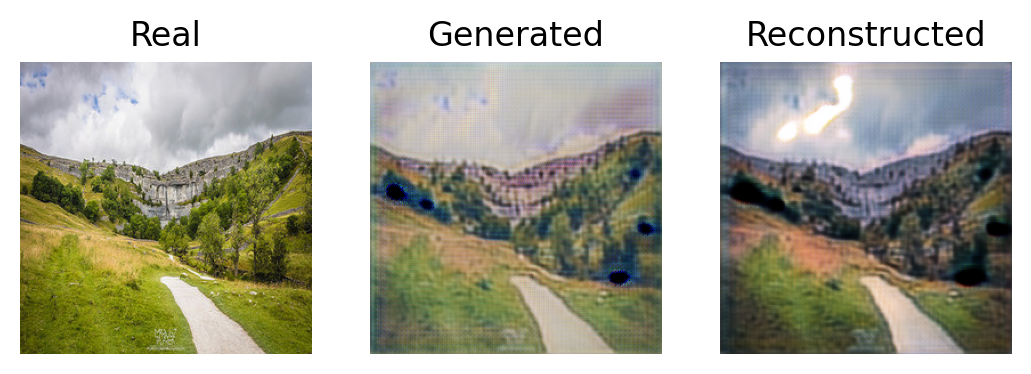

In [18]:
# load dataset
A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=4,    
                 random_state=42) # reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=4,    
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5


# load the models
# cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_002000.h5')
model_BtoA = load_model('g_model_BtoA_002000.h5')

# plot A->B->A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B (Photo to Monet to Photo)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

##########################
#Load a single custom image
test_image = load_img('monet2photo/testB/2014-08-14 15_57_25.jpg')
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5

# plot B->A->B (Photo to Monet to Photo)
monet_generated  = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)